Importing libraries

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Importing Dataset

In [85]:
df = pd.read_csv('./data/Food_insecurity_selected_demographic_characteristics.csv')

Drop unwanted columns

In [86]:
cols_to_drop = [
    'DGUID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL',
    'TERMINATED', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID'
]
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)
df.head()

,REF_DATE,GEO,Demographic characteristics,Household food security status,Statistics,UOM,VALUE,DECIMALS
0,2018,Canada,All persons,Food insecure,Percentage of persons,Percent,16.8,1
1,2019,Canada,All persons,Food insecure,Percentage of persons,Percent,15.9,1
2,2020,Canada,All persons,Food insecure,Percentage of persons,Percent,15.7,1
3,2021,Canada,All persons,Food insecure,Percentage of persons,Percent,18.4,1
4,2022,Canada,All persons,Food insecure,Percentage of persons,Percent,22.9,1


In [87]:
df['Demographic characteristics'].unique()

array(['All persons', 'Persons under 18 years', 'Persons 18 to 24 years',
       'Persons 25 to 34 years', 'Persons 35 to 44 years',
       'Persons 45 to 54 years', 'Persons 55 to 64 years',
       'Persons 65 years and over', 'Males', 'Females',
       'Visible minority population',
       'Indigenous population aged 15 years and over',
       'Recent immigrants (10 years or less) aged 15 years and over'],
      dtype=object)

Rename columns

In [88]:
rename_map = {
    'REF_DATE': 'Year',
    'GEO': 'Region',
    'Household food security status': 'FoodSecurityStatus',
    'Statistics': 'StatisticType',
    'UOM': 'Unit',
    'VALUE': 'Value',
    'DECIMALS': 'Decimals'
}
df.rename(columns=rename_map, inplace=True)

Delete rows with NaN values

In [89]:
df = df.dropna(subset=['Value'])

Drop rows with no target

In [90]:
df = df.dropna(subset=['Value']).reset_index(drop=True)

Make sure 'Year' is numeric

In [91]:
df['Year'] = df['Year'].astype(int)

Feature selection

In [92]:
features = ['Year', 'Demographic characteristics']
target = 'Value'

In [93]:
X = df[features]
y = df[target]

Define preprocessing

In [94]:
categorical = ['Demographic characteristics']
numeric = ['Year']

In [95]:
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numeric)
    ]
)

Build model pipeline

In [96]:
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42))
])

Train-test split and fit

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Evaluation

In [98]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('RMSE:', rmse)

RMSE: 4.381513488889625


Plot Actual vs Predicted

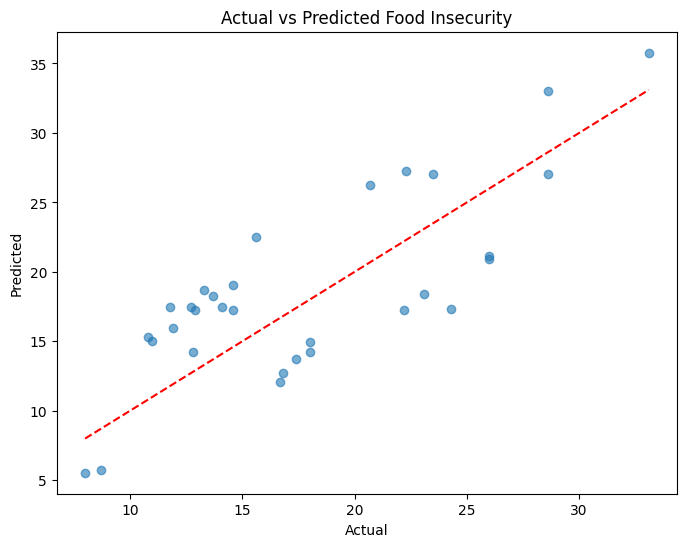

In [99]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Food Insecurity')
plt.show()

List of demographics

In [100]:
demographics = [
    'All persons', 'Persons under 18 years', 'Persons 18 to 24 years',
    'Persons 25 to 34 years', 'Persons 35 to 44 years',
    'Persons 45 to 54 years', 'Persons 55 to 64 years',
    'Persons 65 years and over', 'Males', 'Females',
    'Visible minority population',
    'Indigenous population aged 15 years and over',
    'Recent immigrants (10 years or less) aged 15 years and over'
]

Predict future years

In [101]:
future_years_list = []

# Prepare future data and predict for each demographic
for demo in demographics:
    future_years = pd.DataFrame({
        'Year': [2025, 2026, 2027, 2028, 2029, 2030],
        'Demographic characteristics': [demo] * 6
    })
    
    future_predictions = model.predict(future_years)  # adjust if model needs numeric features
    future_years['Predicted Food Insecurity'] = future_predictions
    future_years_list.append(future_years)

In [102]:
future_all = pd.concat(future_years_list, ignore_index=True)

Plot historical + future forecast

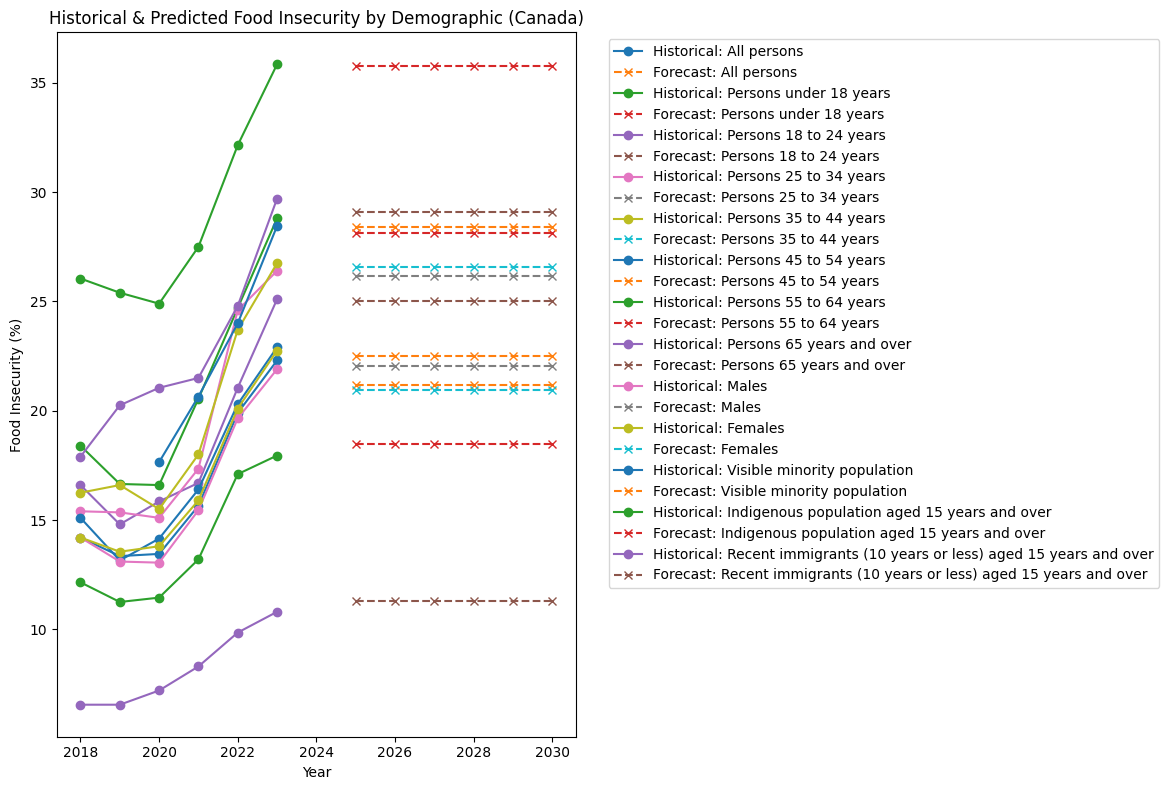

In [103]:
plt.figure(figsize=(12,8))

for demo in demographics:
    # Historical
    historical = df[df['Demographic characteristics'] == demo]
    historical_grouped = historical.groupby('Year')['Value'].mean().reset_index()
    plt.plot(historical_grouped['Year'], historical_grouped['Value'], marker='o', label=f'Historical: {demo}')
    
    # Forecast
    forecast = future_all[future_all['Demographic characteristics'] == demo]
    plt.plot(forecast['Year'], forecast['Predicted Food Insecurity'], marker='x', linestyle='--', label=f'Forecast: {demo}')

plt.xlabel('Year')
plt.ylabel('Food Insecurity (%)')
plt.title('Historical & Predicted Food Insecurity by Demographic (Canada)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # move legend outside plot
plt.tight_layout()
plt.show()